## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75, 0.95]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr =  ReduceLROnPlateau(factor=reduce_factor, 
                                   min_lr=1e-12, 
                                   monitor='val_loss', 
                                   patience=reduce_patient, 
                                   verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0724 13:58:37.867951 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 13:58:37.868949 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 13:58:37.871951 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 13:58:37.940783 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0724 13:58:38.080383 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 13:58:38.088362 19536 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0724 13:58:38.158175 19536 deprecation.py:323] From c:\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 2s 31us/step - loss: 1.2447 - acc: 0.5665 - val_loss: 1.4765 - val_acc: 0.4810
Epoch 15/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2232 - acc: 0.5727 - val_loss: 1.4783 - val_acc: 0.4827
Epoch 16/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.2043 - acc: 0.5803 - val_loss: 1.4706 - val_acc: 0.4848
Epoch 17/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1834 - acc: 0.5899 - val_loss: 1.4610 - val_acc: 0.4880
Epoch 18/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1647 - acc: 0.5981 - val_loss: 1.4657 - val_acc: 0.4831
Epoch 19/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1461 - acc: 0.6045 - val_loss: 1.4776 - val_acc: 0.4822
Epoch 20/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.1292 - acc: 0.6120 - val_loss: 1.4561 - val_acc: 0.4867
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.7716 - acc: 0.3792 - val_loss: 1.8404 - val_acc: 0.3678
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6399 - acc: 0.4241 - val_loss: 1.6965 - val_acc: 0.4036
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5640 - acc: 0.4504 - val_loss: 1.6429 - val_acc: 0.4235
Epoch 5/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5084 - acc: 0.4725 - val_loss: 1.6135 - val_acc: 0.4322
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4642 - acc: 0.4846 - val_loss: 1.5645 - val_acc: 0.4509
Epoch 7/25
50000/50000 [==============================] - 2s 31us/step - loss: 1.4290 - acc: 0.5004 - val_loss: 1.5417 - val_acc: 0.4563
Epoch 8/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.3950 - acc: 0.5108 - val_loss: 1.5270 - val_acc: 0.4610
Epoch 9/25
50000/50000 [=================

Epoch 25/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.1005 - acc: 0.6222 - val_loss: 1.4549 - val_acc: 0.4906
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_laye

Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3219 - acc: 0.5395 - val_loss: 1.5025 - val_acc: 0.4661
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3018 - acc: 0.5447 - val_loss: 1.4854 - val_acc: 0.4769
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2822 - acc: 0.5526 - val_loss: 1.4838 - val_acc: 0.4772
Epoch 16/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2652 - acc: 0.5603 - val_loss: 1.4879 - val_acc: 0.4786
Epoch 17/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2482 - acc: 0.5667 - val_loss: 1.4769 - val_acc: 0.4860
Epoch 18/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2309 - acc: 0.5731 - val_loss: 1.4709 - val_acc: 0.4841
Epoch 19/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.2144 - acc: 0.5790 - val_loss: 1.4741 - val_acc: 0.4842
Epoch 20/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 56us/step - loss: 2.3425 - acc: 0.2427 - val_loss: 2.1807 - val_acc: 0.2957
Epoch 2/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.8328 - acc: 0.3655 - val_loss: 1.8986 - val_acc: 0.3448
Epoch 3/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6947 - acc: 0.4069 - val_loss: 1.7617 - val_acc: 0.3864
Epoch 4/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.6148 - acc: 0.4333 - val_loss: 1.6755 - val_acc: 0.4111
Epoch 5/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5562 - acc: 0.4546 - val_loss: 1.6330 - val_acc: 0.4226
Epoch 6/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.5128 - acc: 0.4697 - val_loss: 1.6014 - val_acc: 0.4369
Epoch 7/25
50000/50000 [==============================] - 2s 32us/step - loss: 1.4755 - acc: 0.4838 - val_loss: 1.5794 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 0.4448 - acc: 0.8714 - val_loss: 1.5399 - val_acc: 0.5163
Epoch 23/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.4261 - acc: 0.8788 - val_loss: 1.5397 - val_acc: 0.5205
Epoch 24/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.4159 - acc: 0.8844 - val_loss: 1.5656 - val_acc: 0.5215
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.4030 - acc: 0.8888 - val_loss: 1.5927 - val_acc: 0.5186
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batc

50000/50000 [==============================] - 2s 33us/step - loss: 1.1893 - acc: 0.5921 - val_loss: 1.4512 - val_acc: 0.4868
Epoch 10/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1632 - acc: 0.5995 - val_loss: 1.4507 - val_acc: 0.4904
Epoch 11/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1401 - acc: 0.6074 - val_loss: 1.4438 - val_acc: 0.4926
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1151 - acc: 0.6178 - val_loss: 1.4374 - val_acc: 0.4915
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0917 - acc: 0.6267 - val_loss: 1.4378 - val_acc: 0.4922
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0713 - acc: 0.6338 - val_loss: 1.4303 - val_acc: 0.4951
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0488 - acc: 0.6431 - val_loss: 1.4464 - val_acc: 0.4899
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.9449 - acc: 0.3379 - val_loss: 1.8833 - val_acc: 0.3674
Epoch 2/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5995 - acc: 0.4388 - val_loss: 1.7145 - val_acc: 0.4011
Epoch 3/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5048 - acc: 0.4744 - val_loss: 1.6222 - val_acc: 0.4293
Epoch 4/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4415 - acc: 0.4965 - val_loss: 1.5800 - val_acc: 0.4500
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3946 - acc: 0.5143 - val_loss: 1.5768 - val_acc: 0.4505
Epoch 6/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3560 - acc: 0.5275 - val_loss: 1.5243 - val_acc: 0.4620
Epoch 7/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3252 - acc: 0.5394 - val_loss: 1.5088 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 1.0552 - acc: 0.6413 - val_loss: 1.4415 - val_acc: 0.4939
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0448 - acc: 0.6459 - val_loss: 1.4367 - val_acc: 0.4959
Numbers of exp: 15, reduce_factor: 0.95, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2270 - acc: 0.5728 - val_loss: 1.4854 - val_acc: 0.4760
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2064 - acc: 0.5799 - val_loss: 1.4666 - val_acc: 0.4887
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1876 - acc: 0.5877 - val_loss: 1.4909 - val_acc: 0.4818
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1710 - acc: 0.5945 - val_loss: 1.4627 - val_acc: 0.4845
Epoch 16/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1537 - acc: 0.6023 - val_loss: 1.4519 - val_acc: 0.4874
Epoch 17/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1378 - acc: 0.6081 - val_loss: 1.4563 - val_acc: 0.4889
Epoch 18/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1240 - acc: 0.6137 - val_loss: 1.4636 - val_acc: 0.4896
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.8524 - acc: 0.3610 - val_loss: 2.4284 - val_acc: 0.2828
Epoch 2/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5431 - acc: 0.4525 - val_loss: 2.2561 - val_acc: 0.2828
Epoch 3/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4260 - acc: 0.4961 - val_loss: 2.0696 - val_acc: 0.3252
Epoch 4/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3454 - acc: 0.5223 - val_loss: 2.4001 - val_acc: 0.2844
Epoch 5/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2772 - acc: 0.5472 - val_loss: 2.0428 - val_acc: 0.3344
Epoch 6/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2198 - acc: 0.5680 - val_loss: 1.6081 - val_acc: 0.4330
Epoch 7/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1707 - acc: 0.5868 - val_loss: 1.7216 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 0.7263 - acc: 0.7590 - val_loss: 2.0655 - val_acc: 0.3701

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 0.6410 - acc: 0.7978 - val_loss: 1.6290 - val_acc: 0.4743
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.6182 - acc: 0.8061 - val_loss: 1.5203 - val_acc: 0.5003
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024  

50000/50000 [==============================] - 2s 33us/step - loss: 1.1927 - acc: 0.5883 - val_loss: 1.5147 - val_acc: 0.4653
Epoch 11/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1589 - acc: 0.5977 - val_loss: 1.4930 - val_acc: 0.4742
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1323 - acc: 0.6085 - val_loss: 1.5420 - val_acc: 0.4608
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1043 - acc: 0.6207 - val_loss: 1.5296 - val_acc: 0.4716
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0768 - acc: 0.6303 - val_loss: 1.5276 - val_acc: 0.4724
Epoch 15/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0509 - acc: 0.6407 - val_loss: 1.6148 - val_acc: 0.4505
Epoch 16/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.0273 - acc: 0.6476 - val_loss: 1.4615 - val_acc: 0.4875
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 89us/step - loss: 2.0248 - acc: 0.3174 - val_loss: 1.9926 - val_acc: 0.3372
Epoch 2/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.6947 - acc: 0.4098 - val_loss: 1.8623 - val_acc: 0.3739
Epoch 3/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.5724 - acc: 0.4490 - val_loss: 1.8218 - val_acc: 0.3783
Epoch 4/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4892 - acc: 0.4765 - val_loss: 1.6780 - val_acc: 0.4168
Epoch 5/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.4296 - acc: 0.4993 - val_loss: 1.6450 - val_acc: 0.4268
Epoch 6/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3784 - acc: 0.5182 - val_loss: 1.5534 - val_acc: 0.4609
Epoch 7/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.3365 - acc: 0.5352 - val_loss: 1.6836 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 0.9344 - acc: 0.6845 - val_loss: 1.4845 - val_acc: 0.4878
Epoch 24/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.9164 - acc: 0.6928 - val_loss: 1.5025 - val_acc: 0.4867
Epoch 25/25
50000/50000 [==============================] - 2s 33us/step - loss: 0.9012 - acc: 0.6977 - val_loss: 1.5599 - val_acc: 0.4705

Epoch 00025: ReduceLROnPlateau reducing learning rate to 8.037890656851231e-05.
Numbers of exp: 25, reduce_factor: 0.95, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024  

50000/50000 [==============================] - 2s 33us/step - loss: 1.3016 - acc: 0.5478 - val_loss: 1.5463 - val_acc: 0.4565
Epoch 10/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2731 - acc: 0.5564 - val_loss: 1.5549 - val_acc: 0.4627
Epoch 11/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2435 - acc: 0.5679 - val_loss: 1.5187 - val_acc: 0.4695
Epoch 12/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.2172 - acc: 0.5775 - val_loss: 1.5353 - val_acc: 0.4687
Epoch 13/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1914 - acc: 0.5882 - val_loss: 1.4911 - val_acc: 0.4821
Epoch 14/25
50000/50000 [==============================] - 2s 33us/step - loss: 1.1684 - acc: 0.5975 - val_loss: 1.4808 - val_acc: 0.4818
Epoch 15/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1447 - acc: 0.6062 - val_loss: 1.4897 - val_acc: 0.4816
Epoch 16/25
50000/50000 [=====================

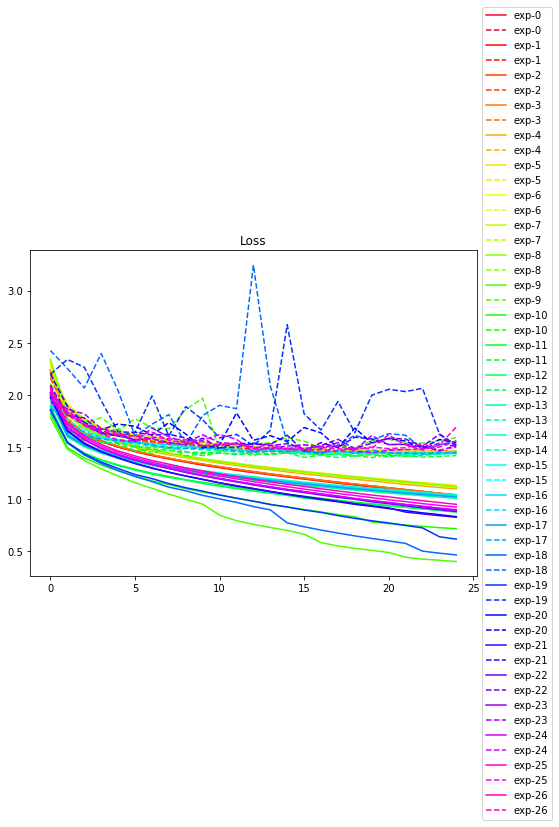

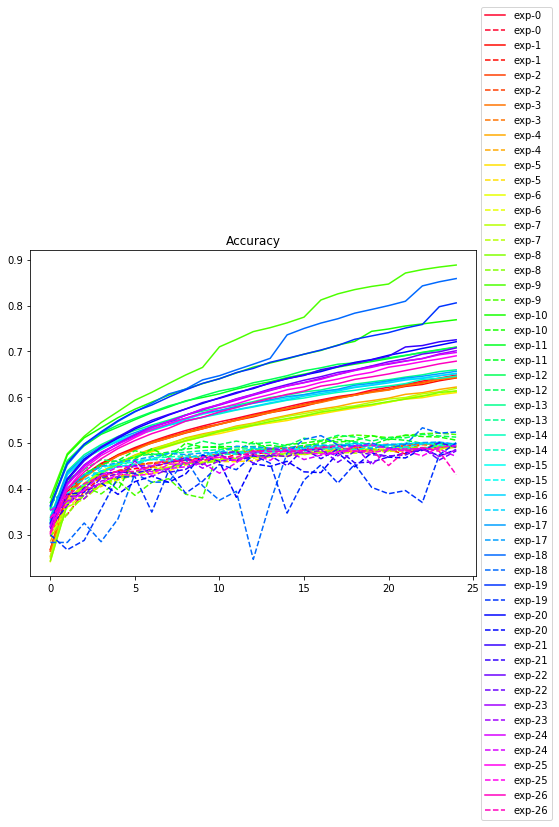

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()